In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Fri Jan 26 17:07:43 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   37C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4_quantize400/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


In [7]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

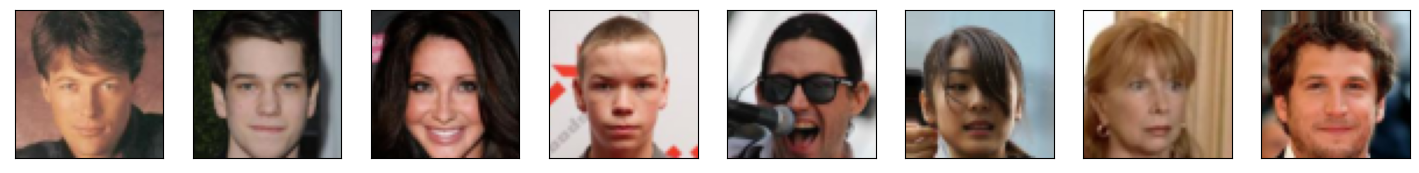

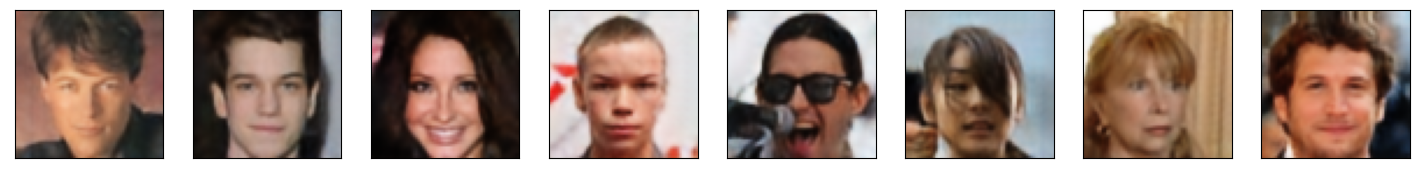

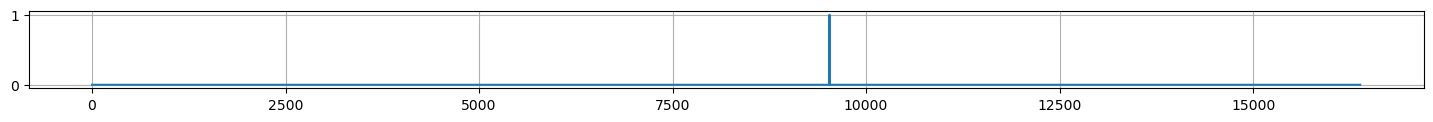

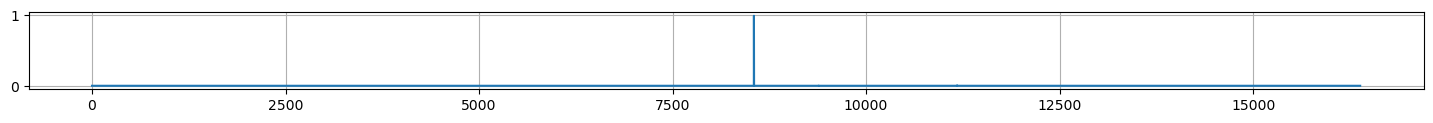

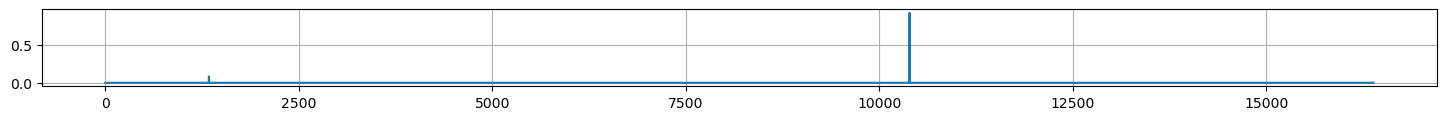

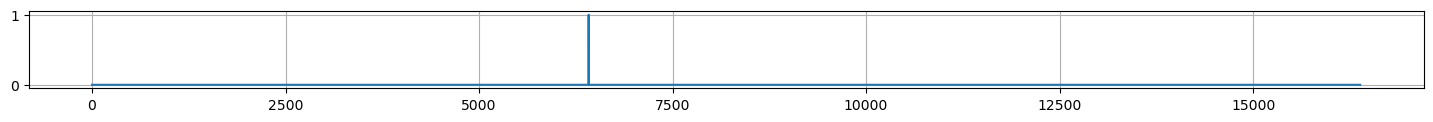

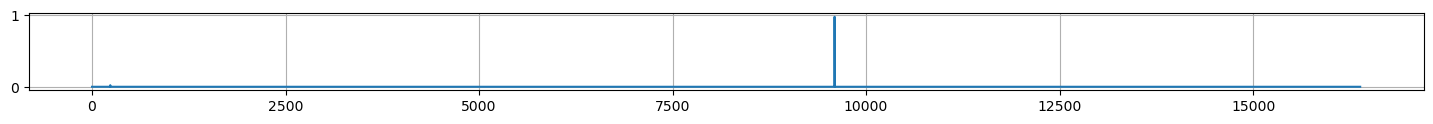

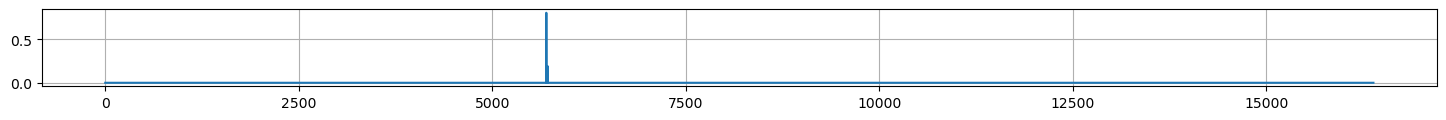

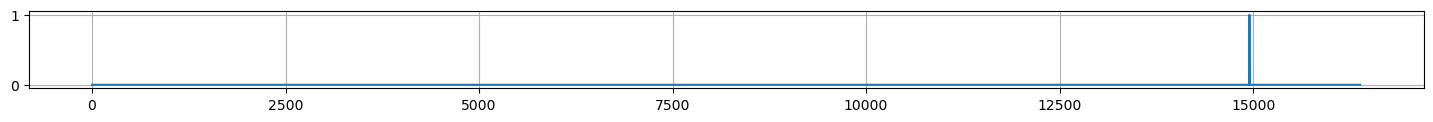

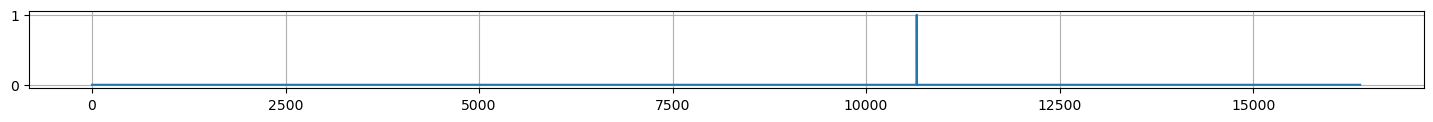

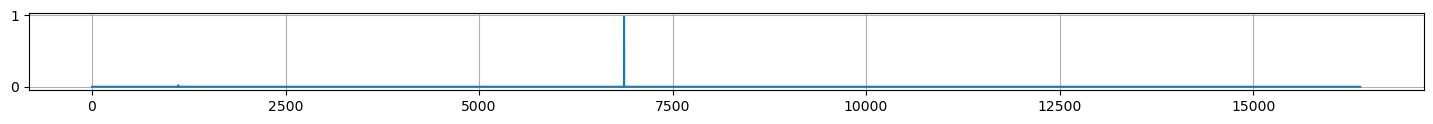

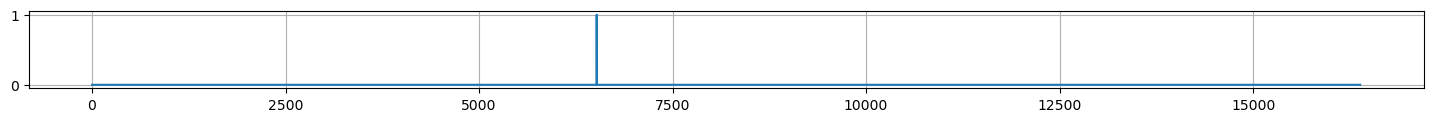

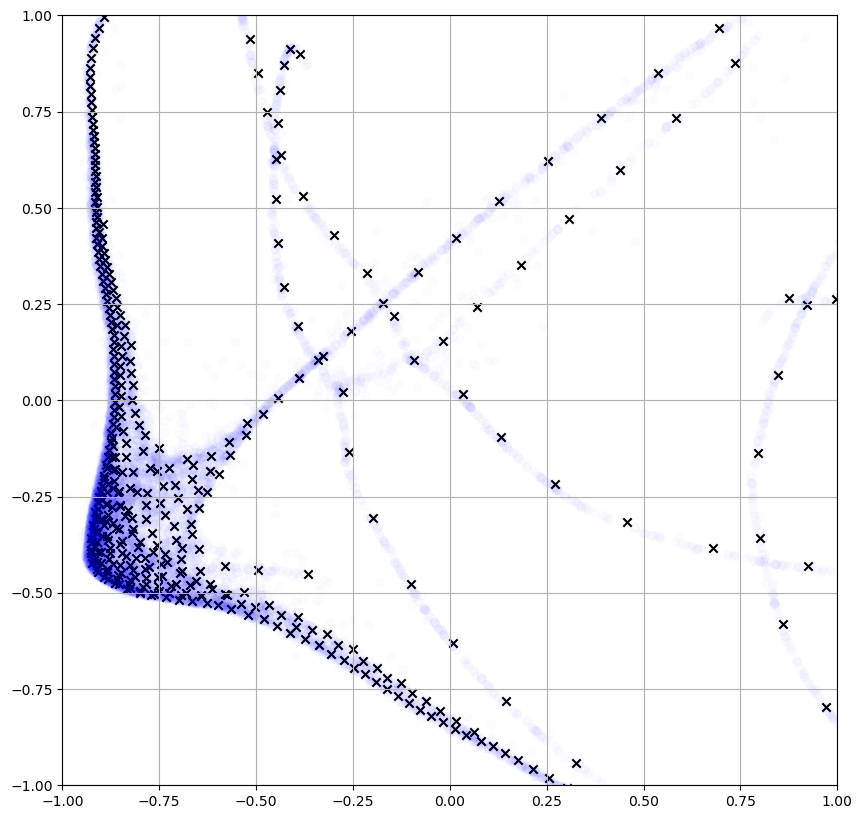

2001
lse_loss -408.81878662109375
commit_loss 7.38618109608069e-05
recon_loss 0.0007095399196259677
2002
lse_loss -398.9598083496094
commit_loss 7.47364028939046e-05
recon_loss 0.0007983437972143292
2003
lse_loss -401.635986328125
commit_loss 7.60267284931615e-05
recon_loss 0.0009689758880995214
2004
lse_loss -406.52630615234375
commit_loss 7.796361023792997e-05
recon_loss 0.0008433253969997168
2005
lse_loss -400.75628662109375
commit_loss 7.390454993583262e-05
recon_loss 0.0007988106808625162
2006
lse_loss -408.8237609863281
commit_loss 7.573448237963021e-05
recon_loss 0.0007710691425018013
2007
lse_loss -408.82989501953125
commit_loss 7.291037036338821e-05
recon_loss 0.0007426511729136109
2008
lse_loss -406.6987609863281
commit_loss 7.759875734336674e-05
recon_loss 0.0007889083353802562
2009
lse_loss -407.6566162109375
commit_loss 7.413812272716314e-05
recon_loss 0.0007397908484563231
2010
lse_loss -410.9649963378906
commit_loss 7.880527118686587e-05
recon_loss 0.000810386030934751
2

lse_loss -414.0802917480469
commit_loss 8.100988634396344e-05
recon_loss 0.000809874851256609
2086
lse_loss -409.4219665527344
commit_loss 7.979634392540902e-05
recon_loss 0.0007589894812554121
2087
lse_loss -414.76947021484375
commit_loss 8.291291305795312e-05
recon_loss 0.0007525378605350852
2088
lse_loss -414.4690856933594
commit_loss 7.87990284152329e-05
recon_loss 0.0007365734782069921
2089
lse_loss -410.3613586425781
commit_loss 7.973203173605725e-05
recon_loss 0.0007457253523170948
2090
lse_loss -402.3244323730469
commit_loss 7.897629257058725e-05
recon_loss 0.000726575031876564
2091
lse_loss -409.25640869140625
commit_loss 7.751349039608613e-05
recon_loss 0.0007584320264868438
2092
lse_loss -411.85357666015625
commit_loss 7.162920519476756e-05
recon_loss 0.0007512645097449422
2093
lse_loss -409.2066955566406
commit_loss 7.545918197138235e-05
recon_loss 0.0008262149058282375
2094
lse_loss -405.8938903808594
commit_loss 8.794560562819242e-05
recon_loss 0.0007968994323164225
2095


2168
lse_loss -398.9594421386719
commit_loss 7.769960211589932e-05
recon_loss 0.0007367929792962968
2169
lse_loss -388.813720703125
commit_loss 8.714519935892895e-05
recon_loss 0.0008036228828132153
2170
lse_loss -408.64111328125
commit_loss 8.522061398252845e-05
recon_loss 0.0007992134778760374
2171
lse_loss -404.1435546875
commit_loss 8.001543756108731e-05
recon_loss 0.0008778332266956568
2172
lse_loss -391.7314453125
commit_loss 8.301383059006184e-05
recon_loss 0.0008216807618737221
2173
lse_loss -406.29522705078125
commit_loss 7.611235923832282e-05
recon_loss 0.0008227112703025341
2174
lse_loss -406.23455810546875
commit_loss 7.640311378054321e-05
recon_loss 0.0007638741517439485
2175
lse_loss -408.11395263671875
commit_loss 7.438072498189285e-05
recon_loss 0.0007006460800766945
2176
lse_loss -412.350830078125
commit_loss 7.508492126362398e-05
recon_loss 0.0007746202754788101
2177
lse_loss -393.6729431152344
commit_loss 7.315948460018262e-05
recon_loss 0.0007358569419011474
2178
ls

lse_loss -404.2160339355469
commit_loss 7.777822611387819e-05
recon_loss 0.0008073844946920872
2253
lse_loss -415.06756591796875
commit_loss 7.103026291588321e-05
recon_loss 0.0007651030900888145
2254
lse_loss -413.9278564453125
commit_loss 7.09376618033275e-05
recon_loss 0.0008242467883974314
2255
lse_loss -413.3294372558594
commit_loss 7.088926213327795e-05
recon_loss 0.00075002561789006
2256
lse_loss -410.0850524902344
commit_loss 7.435691804857925e-05
recon_loss 0.0008346933173015714
2257
lse_loss -408.8565673828125
commit_loss 7.351268141064793e-05
recon_loss 0.0008684921776875854
2258
lse_loss -413.1145324707031
commit_loss 7.88093893788755e-05
recon_loss 0.0008998080156743526
2259
lse_loss -409.9280090332031
commit_loss 7.328328501898795e-05
recon_loss 0.0007690742495469749
2260
lse_loss -406.8748779296875
commit_loss 7.513129094149917e-05
recon_loss 0.0007026257226243615
2261
lse_loss -403.05889892578125
commit_loss 7.008138345554471e-05
recon_loss 0.0007570856250822544
2262
ls

2337
lse_loss -408.1270446777344
commit_loss 7.115340122254565e-05
recon_loss 0.000807488220743835
2338
lse_loss -411.20135498046875
commit_loss 7.2345050284639e-05
recon_loss 0.0008122331346385181
2339
lse_loss -411.8299560546875
commit_loss 7.332234235946089e-05
recon_loss 0.000766985584050417
2340
lse_loss -400.85943603515625
commit_loss 7.518815982621163e-05
recon_loss 0.000878049002494663
2341
lse_loss -409.40081787109375
commit_loss 7.279100100276992e-05
recon_loss 0.0008468282176181674
2342
lse_loss -408.1888732910156
commit_loss 6.563405622728169e-05
recon_loss 0.0007041567005217075
2343
lse_loss -412.521728515625
commit_loss 7.032290159258991e-05
recon_loss 0.0007352206157520413
2344
lse_loss -411.1392822265625
commit_loss 6.940685852896422e-05
recon_loss 0.0007909949636086822
2345
lse_loss -411.0553894042969
commit_loss 7.563945109723136e-05
recon_loss 0.0008403236861340702
2346
lse_loss -410.73883056640625
commit_loss 7.221226405818015e-05
recon_loss 0.0006750136963091791
23

2422
lse_loss -401.33642578125
commit_loss 7.697372348047793e-05
recon_loss 0.0009237051708623767
2423
lse_loss -396.71728515625
commit_loss 7.882127101765946e-05
recon_loss 0.0008575106039643288
2424
lse_loss -405.7273254394531
commit_loss 7.849757093936205e-05
recon_loss 0.0008505516452714801
2425
lse_loss -406.4224853515625
commit_loss 7.458304753527045e-05
recon_loss 0.0008526641759090126
2426
lse_loss -400.1064147949219
commit_loss 7.863018981879577e-05
recon_loss 0.0008353423327207565
2427
lse_loss -402.3196105957031
commit_loss 7.858453318476677e-05
recon_loss 0.0008338968036696315
2428
lse_loss -401.4800109863281
commit_loss 7.250353519339114e-05
recon_loss 0.0007788508082740009
2429
lse_loss -407.82965087890625
commit_loss 7.697883120272309e-05
recon_loss 0.0008179365540854633
2430
lse_loss -399.7044372558594
commit_loss 7.689581252634525e-05
recon_loss 0.0008127136970870197
2431
lse_loss -403.5283508300781
commit_loss 7.524697139160708e-05
recon_loss 0.0007014518487267196
243

2507
lse_loss -401.8162841796875
commit_loss 7.22963668522425e-05
recon_loss 0.000802262919023633
2508
lse_loss -405.0521240234375
commit_loss 7.059800554998219e-05
recon_loss 0.0007587936706840992
2509
lse_loss -399.62457275390625
commit_loss 7.189546886365861e-05
recon_loss 0.0007666863384656608
2510
lse_loss -401.6914367675781
commit_loss 7.769419607939199e-05
recon_loss 0.0008136634714901447
2511
lse_loss -398.0393371582031
commit_loss 8.051181794144213e-05
recon_loss 0.0007610050379298627
2512
lse_loss -400.9964294433594
commit_loss 8.35426471894607e-05
recon_loss 0.0007845120271667838
2513
lse_loss -402.1505126953125
commit_loss 7.480222848244011e-05
recon_loss 0.0008702982449904084
2514
lse_loss -405.1116943359375
commit_loss 7.551221642643213e-05
recon_loss 0.0007185956346802413
2515
lse_loss -402.3659362792969
commit_loss 7.592004840262234e-05
recon_loss 0.0007162436377257109
2516
lse_loss -405.79345703125
commit_loss 7.860087498556823e-05
recon_loss 0.0007568337023258209
2517

2592
lse_loss -404.0513000488281
commit_loss 7.528606511186808e-05
recon_loss 0.0008242906769737601
2593
lse_loss -405.9912414550781
commit_loss 7.45065335649997e-05
recon_loss 0.0007881398196332157
2594
lse_loss -386.2040710449219
commit_loss 7.508027920266613e-05
recon_loss 0.0007351272506639361
2595
lse_loss -410.2850036621094
commit_loss 7.37940426915884e-05
recon_loss 0.0008472047047689557
2596
lse_loss -398.41400146484375
commit_loss 7.422613998642191e-05
recon_loss 0.0008629505755379796
2597
lse_loss -409.5430603027344
commit_loss 7.304544124053791e-05
recon_loss 0.0008250880055129528
2598
lse_loss -408.7945861816406
commit_loss 7.057475886540487e-05
recon_loss 0.0008125820895656943
2599


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 400*1000)
            data = model(data, latent_temp=1, quant_temp=quant_temp)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 